In [1]:
import numpy as np
import sys
import os
import fitsio as fi
import pylab as plt
import numpy.fft as npf
tidal_tensor = {}
galaxy_tidal_tensor = {}

In [39]:
base='/Volumes/groke/work/simulation_data/'

nx = 64 # pixel resolution 128, 64, 32, 16
nxyz = fi.FITS('%s/density/dm_density_099_%d.fits'%(base,nx))[-1].read()
gxyz = fi.FITS('%s/density/star_density_099_%d.fits'%(base,nx))[-1].read()
n0 = int(nxyz.shape[0]/2)


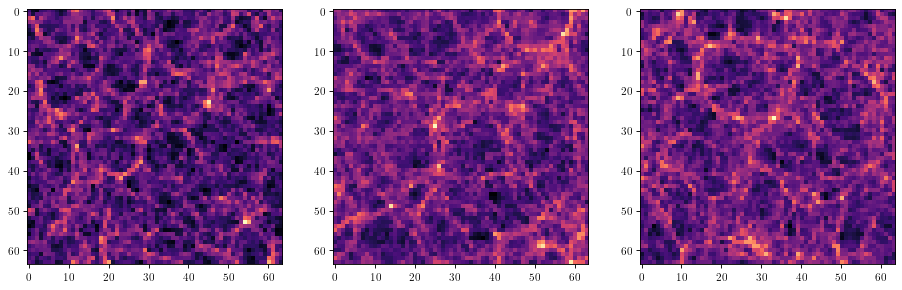

In [40]:
fig=plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(131) ; plt.imshow(np.log10(nxyz[:,:,n0]), interpolation='none', cmap='magma')
plt.subplot(132) ; plt.imshow(np.log10(nxyz[:,n0,:]), interpolation='none', cmap='magma')
plt.subplot(133) ; plt.imshow(np.log10(nxyz[n0,:,:]), interpolation='none', cmap='magma')

In [41]:
# now compute the tidal tensor
k  = npf.fftfreq(nx)[np.mgrid[0:nx,0:nx,0:nx]]
tidal_tensor[nx] = np.zeros((nx,nx,nx,3,3),dtype=np.float32)
galaxy_tidal_tensor[nx] = np.zeros((nx,nx,nx,3,3),dtype=np.float32)

# overdensity field
K = np.mean(nxyz)
d = nxyz/K -1 

g = gxyz/np.mean(gxyz) -1 

# FFT the box
fft_dens = npf.fftn(d) 
galaxy_fft_dens = npf.fftn(g) 

In [42]:
#A=(2.*np.pi)**3/nx
#A=-(2*np.pi)**3/nx/nx/nx

A=-300./nx / (2*np.pi)**3/100 # physical pixel scale
A = 1.

for i in range(3):
    for j in range(3):
        print(i,j)
        # k[i], k[j] are 3D matrices
        temp = fft_dens * k[i]*k[j]/(k[0]**2 + k[1]**2 + k[2]**2)
        galaxy_temp = galaxy_fft_dens * k[i]*k[j]/(k[0]**2 + k[1]**2 + k[2]**2)
        
        # subtract off the trace...
        if (i==j):
            temp -= 1./3 * fft_dens
            galaxy_temp -= 1./3 * galaxy_fft_dens
        
        temp[0,0,0] = 0
        tidal_tensor[nx][:,:,:,i,j] = A * npf.ifftn(temp).real
        galaxy_temp[0,0,0] = 0
        galaxy_tidal_tensor[nx][:,:,:,i,j] = A * npf.ifftn(galaxy_temp).real

0 0
0 1
0 2
1 0
1 1


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


1 2
2 0
2 1
2 2


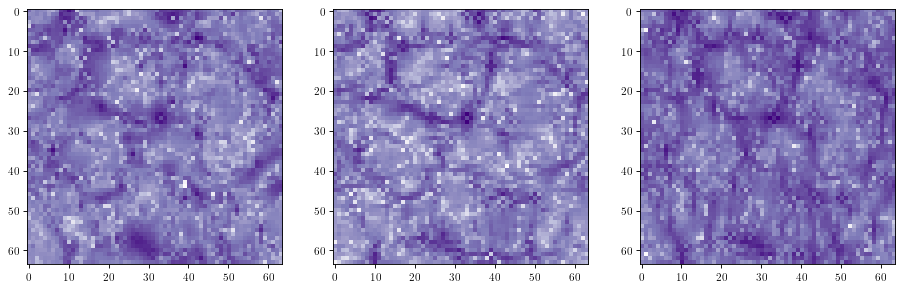

In [43]:
fig=plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(131)
plt.imshow(np.log10(abs(tidal_tensor[nx][n0,:,:,0,0])), interpolation='none', cmap='Purples')
plt.subplot(132)
plt.imshow(np.log10(abs(tidal_tensor[nx][n0,:,:,1,1])), interpolation='none', cmap='Purples')
plt.subplot(133)
plt.imshow(np.log10(abs(tidal_tensor[nx][n0,:,:,2,2])), interpolation='none', cmap='Purples')

In [44]:
# shape catalogue, to be converted to a grid
cat = fi.FITS(base+'shape_cats/TNG300-1_99_non-reduced_galaxy_shapes.fits')[-1].read()

def get_trace_free_matrix(I):
    ndim = len(I[0])   
    T = np.matrix.trace(I)
    K = 1./float(ndim) * T * np.identity(ndim)
    I_TF = I - K
    return I_TF

ngal = len(cat['x'])
gammaI = np.zeros((nx,nx,nx,3,3))
num = np.zeros((nx,nx,nx,3,3))

L = 300 * 0.69 # box size in Mpc/h 
B = np.linspace(0,L,nx+1)
lower,upper = B[:-1],B[1:]

# Compute the shape cube by adding galaxies one at a time to cells
for i in range(ngal):
    #print ("Processing galaxy %d/%d"%(i,ngal))
    
    # put this galaxy into a cell
    info = cat[i]
    ix = np.argwhere((cat['x'][i]>=lower) & (cat['x'][i]<upper))[0,0]
    iy = np.argwhere((cat['y'][i]>=lower) & (cat['y'][i]<upper))[0,0]
    iz = np.argwhere((cat['z'][i]>=lower) & (cat['z'][i]<upper))[0,0]
    
    # reconstruct the 3x3 shape matrix for this galaxy
    a0 = np.array([cat['av_x'][i],cat['av_y'][i],cat['av_z'][i]])
    b0 = np.array([cat['bv_x'][i],cat['bv_y'][i],cat['bv_z'][i]])
    c0 = np.array([cat['cv_x'][i],cat['cv_y'][i],cat['cv_z'][i]])
    V = np.diag(np.array([cat['a'][i]**2, cat['b'][i]**2, cat['c'][i]**2]))
    v = np.array([a0,b0,c0])
    v0=np.linalg.inv(v)
    I = np.dot(v0,np.dot(V,v))
    
    I_TF = get_trace_free_matrix(I)
    
    # add it to the correct cell
    gammaI[ix,iy,iz,:,:] += I_TF    
    num[ix,iy,iz,:,:] += 1

gammaI /= num
gammaI[np.isinf(gammaI)]=-9999.
gammaI[np.isnan(gammaI)]=-9999.



/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


171684


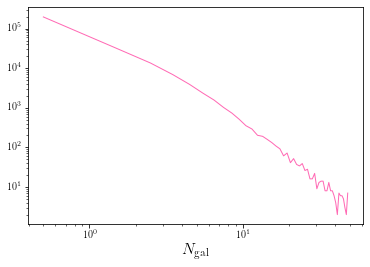

In [45]:
# plot the distribution of occupation numbers of the cells
H,b=np.histogram(num[:,:,:,0,0].flatten(), bins=np.arange(0,50,1))
n=(b[:-1]+b[1:])/2
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$N_{\rm gal}$', fontsize=16)
plt.plot(n,H,color='hotpink')
print(len(cat))

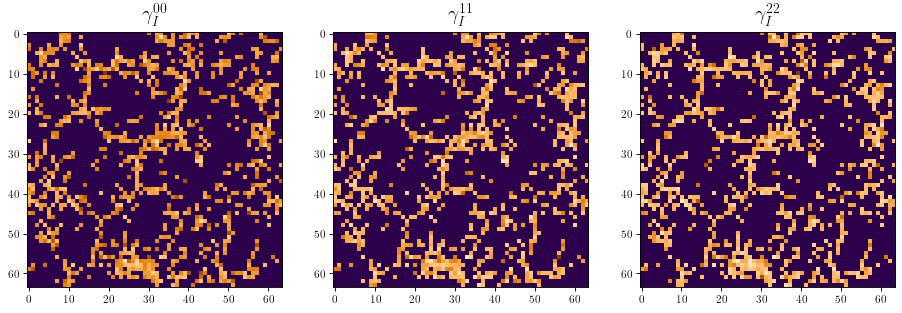

In [46]:
fig=plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(131)
plt.title('$\gamma_I^{00}$', fontsize=18)
plt.imshow(np.log10(abs(gammaI[n0,:,:,0,0])), interpolation='none', cmap='PuOr')
plt.subplot(132)
plt.title('$\gamma_I^{11}$', fontsize=18)
plt.imshow(np.log10(abs(gammaI[n0,:,:,1,1])), interpolation='none', cmap='PuOr')
plt.subplot(133)
plt.title('$\gamma_I^{22}$', fontsize=18)
plt.imshow(np.log10(abs(gammaI[n0,:,:,2,2])), interpolation='none', cmap='PuOr')

2.1
0.9982051847512636


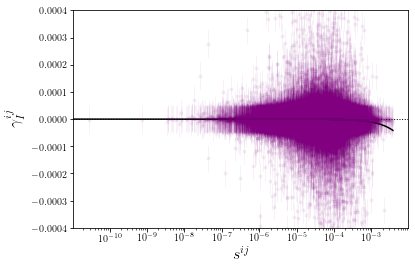

In [49]:
# cosmology dependent prefactors
CONST = -0.005307
CONST2 = 0.033832
# IA parameters
A1 = 2.1
A2 = 0.

C1 = A1 * CONST 
C2 = A2 * CONST2

bias_ta = 0.
C1d = bias_ta * C1 

print(A1)

D = gammaI[:,:,:].flatten() # data vec - gridded shape tensor
mask = (D!=-9999) # throw out empty cells

F = 2.85
A = F**(128./nx) * (2*np.pi)**-3 / 300. # !!!!!!!! <---------- needed to get A~1

x = tidal_tensor[nx][:,:,:].flatten() * A
gx = galaxy_tidal_tensor[nx][:,:,:].flatten() * A
T = (C1 * x) + (C1d*gx) # model prediction for gammaI, given the tidal field

dy = np.ones_like(D) * np.std(D[(D!=-9999.)])

chi2 = (D[mask] - T[mask] )**2 
chi2 = chi2 / dy[mask] / dy[mask]
chi2 = np.sum(chi2)
print(chi2/len(D[mask]))

f=3
plt.errorbar(x[mask][::f],D[mask][::f],yerr=dy[mask][::f],linestyle='none',color='purple', marker='.', alpha=0.05)

xf = np.linspace(x.min(),x.max(),1000)
plt.plot(xf,xf*C1, '-', color='k', lw=1.5)
plt.xlabel('$s^{ij}$',fontsize=16)
plt.ylabel('$\gamma_I^{ij}$',fontsize=16)
plt.ylim(-0.0004, 0.0004)
plt.xscale('log')
plt.axhline(0,color='k',ls=':')

[2.73073073]


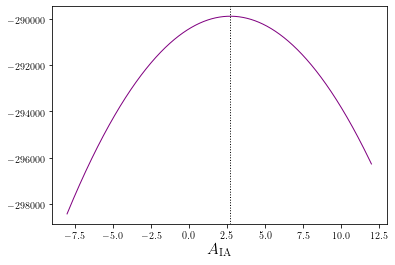

In [50]:
A=np.linspace(-8,12,1000)


chi2=[]
for a in A:
    c1 = a * CONST 
    T = (c1 * x)
    R = T[mask]-D[mask] 
    X = (R * R)/ dy[mask] / dy[mask]
    X = np.sum(X)
    chi2.append(X)



L0 = -0.5 * np.array(chi2)
#-2*np.log(chi2)
plt.plot(A, L0, color='purple')
P = A[(L0==L0.max())]
plt.axvline(P, color='k', ls=':')
plt.xlabel(r'$A_{\rm IA}$', fontsize=16)
print(P)
